In [1]:
from IPython.display import Image
from IPython.core.display import HTML
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import sympy as sp
from sympy.plotting import plot
import operator
from scipy.special import roots_laguerre

import timeit

np.seterr(all="ignore")

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

# Functions for plotting and solving ODE's

In [2]:
# Returns a list of points (2-tuples) for each solution to the system of equations.
# If the nullclines are on top of each other, this method may produce unexpected results.
def nullcline_intersection(sys, r):
    x, y = sp.symbols('x, y')
    eq1 = sys(x, y, r)[0]
    eq2 = sys(x, y, r)[1]
    sols = sp.solve([eq1, eq2], [x, y])
    return np.array(sols,dtype=float)

def plot_nullclines(sys, linx, liny):
    t, x, y = sp.symbols('t, x, y')
    eq1 = sys[0](t, x, y)
    eq2 = sys[1](t, x, y)
    
    nullcline_x = sp.solve(eq2,x )[0] #x = f(y)
    nullclines = plot(nullcline_x)
    
    return nullclines
    

# sys is as above, x_window and y_window are lists/tuples containing the ranges for the window.
# ex: plot_flow(sys, [0, 10], [5, 15]) goes from 0 to 10 on the x axis and 5 to 15 on the y axis.
def plot_flow(sys, x_window, y_window, num_arrows, t=0):
    
    linx = np.linspace(x_window[0], x_window[1], num_arrows)
    liny = np.linspace(y_window[0], y_window[1], num_arrows)
    X, Y = np.meshgrid(linx, liny)
    
    Xa = sys[0](t, X, Y)
    Ya = sys[1](t, X, Y)
    
    n = np.sqrt(Xa*Xa + Ya*Ya)
    plt.title('Slope Field and Nullcline Intersections');
    plt.quiver(X, Y, Xa/n, Ya/n, color='g');
    
    #intersections = nullcline_intersection(sys)
    #for pt in intersections:
    #    print(f'Intersection at: {pt}')
    #    plt.plot([0], pt[1], 'bo');
        
    
    #nullcline_y = sp.solve(Xa,x)[0] #y = f(x)
    #print(nullcline_y)       
    #p1 = plot_nullclines(sys, linx, liny)
    
        
# Generates the numerical solution to an Initial Value Problem. Returns a tuple of all the times that the system was sampled at
# and a list of the corresponding states.
# sys    - list of 2 functions to solve
# init   - list of initial values for the system
# tspan  - list of beginning time and ending time
# h      - step size
# stopfn - a function that takes two arguments, time and the current state of the system. When the lambda returns a truthy value 
#          the solver will halt.
def solve_IVP(sys, init, tspan, h=None, is_forward=None):
    
    def compare(a, relate, b):
        return relate(a,b)
      
    # Check for span errors
    if tspan[0] == tspan[1]:
        print('Please make the timespan a list of two distinct values.')
    
    def wrap(sys):
        def F(t,state):
            return np.array([sys[0](t, state[0], state[1]), sys[1](t, state[0], state[1])])
        return F
    
    def rk4(t,y,h,func):
        k1 = h*func(t,y)
        k2 = h*func(t+0.5*h,y+0.5*k1)
        k3 = h*func(t+0.5*h,y+0.5*k2)
        k4 = h*func(t+h,y+k3)
        return (k1 + 2*k2 + 2*k3 + k4) / 6
    
    def rk4_solve(t0,tf,h,y0,func,relation):
        # print('(t0,tf,h,y0,func,stopfn)')
        # print(t0,tf,h,y0,func,stopfn)
        tv, yv, = [], [] # Results
        t, y = t0, y0 # Current state
        
        while (compare(t,relation,tf)):
            y += rk4(t,y,h,func) 
            t += h
            yv.append(y.copy())
            tv.append(t)
        return np.array(tv), np.array(yv)
    
    return rk4_solve(tspan[0], tspan[1], h, init, wrap(sys), is_forward)


def plot_IVP(sys, init, tspan, h=None, is_forward=None):
    # Choose the missing parameters
    forward = tspan[1] > tspan[0]
    if is_forward == None:    
        is_forward = operator.lt if forward else operator.gt
        #print(f'Choosing stopping method {"forward" if forward else "backward"}.')
    if h == None:
        h = .01 if forward else -.01
        #print(f'Choosing step size {h}.')
    t,v = solve_IVP(sys, init, tspan, h, is_forward)
    plt.plot(v[:,0],v[:,1],'y--');
    #plt.plot(init[0], init[1], 'r.')
    return t,v

# Taylor approximation at x0 of the function 'function'. The degree of the resulting polynomial is n.
def taylor(function,x0,n):
    x, y = sp.symbols('x, y')
    eq = function(x, y)
    
    def factorial(n):
        return 1 if n <= 0 else n*factorial(n-1)
    i = 0
    p = 0
    while i <= n:
        p = p + (eq.diff(x,i).subs(x,x0))/(factorial(i))*(x-x0)**i
        i += 1
    return sp.simplify(p)

In [3]:
def plot_time_series(sys, init, tspan, h=None, is_forward=None):
    # Choose the missing parameters
    forward = tspan[1] > tspan[0]
    if is_forward == None:    
        is_forward = operator.lt if forward else operator.gt
        #print(f'Choosing stopping method {"forward" if forward else "backward"}.')
    if h == None:
        h = .01 if forward else -.01
    #print(f'Choosing step size {h}.')
    t,v = solve_IVP(sys, init, tspan, h, is_forward)
    plt.plot(t,v[:,1],'y--');
    plt.plot(t[0], init[1], 'r.')
    plt.xlabel('$t$',size=20)
    return t,v

# Linearizing the System using the Jacobian

In [4]:
# Returns a matrix of functions in the first variable of the system and the second variable of the system.
def jacobian(sys, t=0):
    def to_func(s):
        return eval(f'lambda t, x, y : {s.__repr__()}')
    x, y = sp.symbols('x, y')
    x_eq = sys[0](t, x, y)
    y_eq = sys[1](t, x, y)
    jac = [ [ sp.Derivative(x_eq, x).doit(), sp.Derivative(x_eq, y).doit() ], [ sp.Derivative(y_eq, x).doit(), sp.Derivative(y_eq, y).doit()] ]
    fnr1 = [ to_func(e) for e in jac[0] ]
    fnr2 = [ to_func(e) for e in jac[1] ]
    return [fnr1, fnr2]

# Creates the jacobian for the system and solves it at the point (x, y) at a certain point in time.
def jacobian_at_a_point(sys, x, y, t=0):
    jac = jacobian(sys, t)
    return eval_jacobian(jac, t, x, y)

# x - value for first variable
# y - value for second variable
def eval_jacobian(jac, t, x, y):
    return [[float(jac[0][0](t,x,y)),float(jac[0][1](t,x,y))],[float(jac[1][0](t,x,y)),float(jac[1][1](t,x,y))]]

def print_jacobian(sys):
    t, x, y = sp.symbols('t, x, y')
    x_eq = sys[0](t, x, y)
    y_eq = sys[1](t, x, y)
    jac = [ [ sp.Derivative(x_eq, x).doit(), sp.Derivative(x_eq, y).doit() ], [ sp.Derivative(y_eq, x).doit(), sp.Derivative(y_eq, y).doit()]]
    print(jac)
    return jac
def jacsysFC(k,c,r):
    # G1 = dc/dt
    # G2 = dk/dt
    # J = [dG1/dc, dG1/dk
    #      dG2/dc, dG2/dk]
    alpha, delta, xt, n, rho, b, gamma = r[0], r[1], r[2], r[3], r[4], r[5], r[6]
    J = np.array([[alpha*k**(alpha-1)-(delta+xt+n), -1],
    [c*alpha*(alpha-1)*k**(alpha-2), alpha*k**(alpha-1) - (delta+xt) - rho]])
    return J

# Jacobian of the Full Comittment Case
def dFull(k,c,r):
    alpha, delta, xt, n, rho, b, gamma = r[0], r[1], r[2], r[3], r[4], r[5], r[6]
    G1 = k**alpha - (delta+xt+n)*k - c
    G2 = c*(alpha*k**(alpha-1) - (delta+xt) - rho) # b*exp(-gamma*t) -> 0 as t -> infty
    # returning the array [dK, dC]
    return [G1, G2]

# Jacobian of the No Comittment Case
def dNo(k,c,r):
    alpha, delta, xt, n, rho, b, gamma = r[0], r[1], r[2], r[3], r[4], r[5], r[6]
    G1 = k**alpha - (delta+xt+n)*k - c
    G2 = c*(alpha*k**(alpha-1) - (delta+xt) - lam)
    # returning the array [dK, dC]
    return [G1, G2]

def dJ(k,c,r):
    return [r[0]*k+r[1]*c,r[2]*k+r[3]*c]

## using keiths notes on full commitment
def rk4(t,y,h,func,J):
    k1 = h*func(t,y,J)
    k2 = h*func(t+0.5*h,y+0.5*k1,J)
    k3 = h*func(t+0.5*h,y+0.5*k2,J)
    k4 = h*func(t+h,y+k3,J)
    return (k1 + 2*k2 + 2*k3 + k4)/6

# Homebrew Solver: Euler's Method
def rk4_solve(t0,tf,h,y0,func,J):
    tv, yv, = [], []
    t, y = t0, y0
    while t < tf:
        y += rk4(t,y,h,func,J)
        t += h
        yv.append(y.copy())
        tv.append(t)
    return np.array(tv), np.array(yv)

def F(t,U,J):
    # System of Equations
    return np.array([ J[0,0]*U[0] + J[0,1]*U[1],
                      J[1,0]*U[0] + J[1,1]*U[1]])

# Gauss Laguerre Quadrature:

$\int_{0}^{+\infty} e^{-x} f(x) d x \approx \sum_{i=1}^{n} w_{i} f\left(x_{i}\right)$

In [5]:
def gauss_laguerre_quadrature(f,conversion,N):
    
    x,w = roots_laguerre(N)
    
    #need to become e^(-x)
    x=x*conversion
    w=w*conversion

    return sum(f(x)*w)

# Ramsey Model - original functions

\begin{array}{l}
\frac{d c}{d t}=0.5 \mathrm{ck}^{-0.5}-0.1 c \\
\frac{d k}{d t}=k^{0.5}-c
\end{array}

In [7]:
sys = [lambda t, k,c : k**0.5 - c, lambda t, k,c : 0.5*c*(k)**(-0.5) - 0.1*c]

### forward-solve:

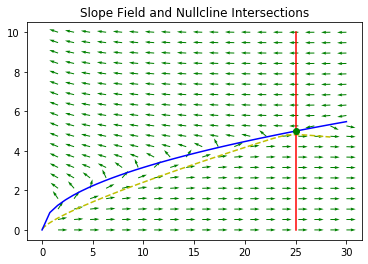

In [8]:
plot_flow(sys, [0, 30], [0, 10], 20)

#solving forward:
tf = 74

plot_IVP(sys, [0.01285009, 0.02446086], [0, tf]);

#add isoclines:
k = np.linspace(0,30,40)
c = np.sqrt(k) # dk = sqrt(k) - c with dk = 0
# dc = 0 implies 0.5/sqrt(k) - 0.1 = 0 so k = 25
plt.plot(k,c,'b',[25,25],[0,10],'r',25,5,'go');

### backward-solve:

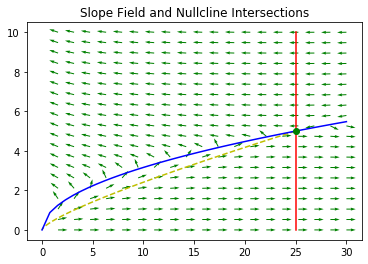

In [9]:
plot_flow(sys, [0, 30], [0, 10], 20)

k0 = 25
error = 0.01
c0 = 5-error
tf =300 

plot_IVP(sys, [k0, c0], [tf, 0]);

#add isoclines:
k = np.linspace(0,30,40)
c = np.sqrt(k) # dk = sqrt(k) - c with dk = 0
# dc = 0 implies 0.5/sqrt(k) - 0.1 = 0 so k = 25
plt.plot(k,c,'b',[25,25],[0,10],'r',25,5,'go');

# Ramsey Model - Barro adds depreciation and some discounting

\begin{array}{l}
\dot{c}=c\left(\alpha k^{\alpha-1}-\delta-\frac{\rho}{\beta}\right) \\
\dot{k}=k^{\alpha}-c-\delta k
\end{array}

In [10]:
#use plot vector field
#k is x, c is y
#sys = [ lambda t, k, c : k**0.5 - c, lambda t, k, c : 0.5 * c * k**(-0.5) - 0.1*c ]
Œ± = .5; Œ¥=.1; œÅ=.05; Œ≤=.5
k_prime = lambda t, k, c : k**(Œ±) - c - Œ¥*k
c_prime = lambda t, k, c : c*(Œ±*k**(Œ±-1) - Œ¥ - (œÅ/Œ≤))
sys = [k_prime, c_prime]

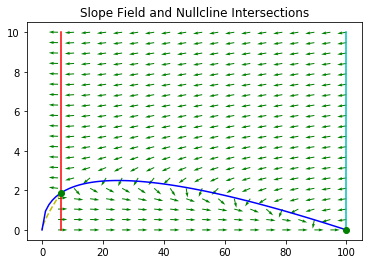

In [11]:
plot_flow(sys, [0, 100], [0, 10], 20)

#backward solves the system:
tf = 200
t, v = plot_IVP(sys, [6.25, 1.875-.01], [tf,0]);

k = np.linspace(0,100,90)
isocline_c = lambda k : k**Œ± - Œ¥*k
plt.plot(k,isocline_c(k),'b',[6.25,6.25],[0,10],'r',[100,100],[0,10],'c',100,0,'go',6.25,1.875,'go');


# Barro's Modification of the Ramsey Function

### Barro adds present bias and commitment technologies (sorta) by adding ùúÜ, which is solved for here:

##### we can approximate Œ© which is defined as:

$\Omega=e^{-(b / \gamma)} \int_{0}^{\infty} e^{(b / \gamma)\left(e^{-\gamma v}\right)} e^{-\rho v} d v$

##### And adding n for the effective workers we get:

$\Omega \equiv \int_{0}^{\infty} e^{-[(\rho-n) v+\phi(v)]} d v$
 
##### where ùúô(ùë£)  is defined as:

$\phi(v)=(b / \gamma) \cdot\left(1-e^{-\gamma v}\right)$ 

which represents present bias.

### lambda is then solved for like this:

$\lambda=n+(1 / \Omega)$

more technically, ùúÜ represents the "effective" rate of time preference, effective implying we are linearlizing the time preference to find its approximation i.e. how much present bias is effecting our decision. It will be a lot in the short term and less in the long term.

and where 

${œÅ ‚â§ ùúÜ ‚â§ œÅ+ùúô'(0)}$ 

and $œÅ$ would be our general appreciation without present bias

ùúÜ plays a role in finding the steady state solutions for $\dot{k}$ and $\dot{c}$, which are defined as:

$ \begin{array}{l}
\dot{c}=c\left(\alpha k^{\alpha-1}-\delta-x-\rho-b e^{-\gamma(t-\tau)}\right) \\
\dot{k}=k^{\alpha}-c-(\delta+x+n) k
\end{array}$

To find the steady state solutions, each equation is set equal to zero, and $\rho-b e^{-\gamma(t-\tau)}$ is replaced with either $\lambda$ or $\rho$ within the first equation, $\dot{c}$, depending on whether we are solving the short-term or long-term steady state solution

When solving using $\lambda$ (for the short-term steady state solution):

$\dot{c}=0=\alpha k^{\alpha-1}-\delta-x-\lambda$

we are also solving for what is known as the no commitment steady state. This is because, in the short term, it is like there is no commitment technologies effecting the present bias, so the present bias $\lambda$ is very present. This results in the short-term capital steady state,  $k_{0}^{*}$, and the short_term consumption steady state,  $c_{0}^{*}$

when solving using $\rho$ (for the long-term steady state solution):

$\dot{c}=0=\alpha k^{\alpha-1}-\delta-x-\rho$

we are also solving for what is known as the full commitment steady state. This is because, in the long term, present bias is no longer effective and it disapears, becoming the base amount of utility that we can foresee from the capital without present bias affecting our judgement, $\rho$.

This also means that $\left(k_{\infty}^{*}-k_{0}^{*}\right) / k_{0}^{*}$ is the relative measure between our long-term capital and our short-term capital. In other words, this is the difference between our long-term steady state and our short-term steady state of capital. The same applies to the relative measure of consumption,  $\left(c_{\infty}^{*}-c_{0}^{*}\right) / c_{0}^{*}$ .


##### Barro's Full commitment:

$ \begin{array}{l}
\dot{c}=c\left(\alpha k^{\alpha-1}-\delta-x-\rho-b e^{-\gamma(t-\tau)}\right) \\
\dot{k}=k^{\alpha}-c-(\delta+x+n) k
\end{array}$

##### Barro's No commitment:

$ \begin{array}{l}
\dot{c}=c\left(\alpha k^{\alpha-1}-\delta-x-\lambda\right) \\
\dot{k}=k^{\alpha}-c-(\delta+x+n) k
\end{array}$

In [12]:
full_commitment = [lambda t, k,c : k**Œ±-c-(Œ¥+x+n)*k, lambda t, k,c : c*(Œ±*k**(Œ±-1)-Œ¥-x-œÅ-b*np.exp(-Œ≥*(t-œÑ)))]
no_commitment = [lambda t, k,c : k**Œ±-c-(Œ¥+x+n)*k, lambda t, k,c : c*(Œ±*k**(Œ±-1)-Œ¥-x-Œª)]

##### Barro adds present bias and commitment technologies (sorta)

In [13]:
#Œ≥, b, œÅ, Œ¥, x, Œ±, œÑ, n, Œª = 0.5, 0.5, 0.02, 0.05, 0.01, 0.75, 0.0, 0.01, 0.036528

Œ± = 0.75 # modifies the output function, as in how much output we get out given our capital
Œ¥ = 0.05 # represents the depreciation of capital
x = 0.02 # represents the cost of technological upkeep
b = 0.5  # b represents the upper bound of present bias
œÅ = 0.02 # represents the amount of base utility we get without present bias affecting it
Œ≥ = 0.5  # represents how effective present bias is (in the short-term)
œÑ = 0.0  # represents the current day, where œÑ=0 means time starts today 
n = 0.01 # represents the cost of effective worker upkeep
Œª = 0.036528 # represents present bias

In [14]:
# for use of the Gauss-Laguerre Quadrature when solving for lambda:
# f(x) = e^(-phi'(v))
def f(x):
    return np.exp( -((b/Œ≥)*(1-np.exp(-Œ≥*x))))

In [15]:
N=100
data = [[0.75,0.75,0.75, 0.33, 0.33, 0.33],
        [ 0.5, 0.2, 0.1,  0.5,  0.2,  0.1],
        [],
        [],
        []]

Œª_data = []
b_data = data[1]

kinf_steady = []
cinf_steady = []
k0_steady = []
c0_steady = []

for b in b_data:
    convertWith = 1/(œÅ-n)
    Œ© = gauss_laguerre_quadrature(f,convertWith,N)
    Œª = n + 1/Œ©
    Œª_data.append(Œª)
data[2] = Œª_data

alpha = data[0]
k_relative_measure = []
c_relative_measure = []

for i in range(6):
    kinf = ((Œ¥+x+œÅ)/alpha[i])**(1/(alpha[i]-1))
    cinf = kinf**alpha[i]-(Œ¥+x+n)*kinf
    kinf_steady.append(kinf)
    cinf_steady.append(cinf)
    #print(kinf)
    #print(cinf)
    
    k0=((Œ¥+x+Œª_data[i])/alpha[i])**(1/(alpha[i]-1))
    c0 = k0**alpha[i]-(Œ¥+x+n)*k0
    k0_steady.append(k0)
    c0_steady.append(c0)
    #print(k0)
    print(c0)
    
    k_rm = (kinf-k0)/k0
    c_rm = (cinf-c0)/c0
    k_relative_measure.append(k_rm)
    c_relative_measure.append(c_rm)
        
data[3] = k_relative_measure
data[4] = c_relative_measure

table = pd.DataFrame(data[:5], columns=["(1)","(2)","(3)","(4)","(5)","(6)"], 
                     index = ["Œ±","b = œÜ'(0)", "Œª", 
                              '<img src="https://cdn.discordapp.com/attachments/557363729759469578/726067490941304932/unknown.png" alt="img">', 
                              '<img src="https://cdn.discordapp.com/attachments/557363729759469578/726084138192339024/unknown.png" alt="img">'])
display(HTML(table.to_html(escape=False)))

152.41947882152192
181.79345158857245
188.06452700089557
1.3127463226618776
1.333711947728847
1.3374239826229046


In [16]:
# for use of the Gauss-Laguerre Quadrature when solving for lambda:
# f(x) = e^(-phi'(v))
def f(x):
    return np.exp( -((b/Œ≥)*(1-np.exp(-Œ≥*x))))

In [17]:
table_i=0 #location in the table

Œ±=alpha[table_i]
Œª = Œª_data[table_i]
b = b_data[table_i]
print(.25*k0_steady[table_i])

614.219878045033


# Forward Solve the system of equations given c0 and k0: 

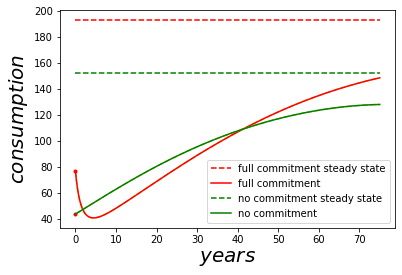

In [18]:
#k0 = 0.25*k_steady
k0 = 614.22
tf = 75

#full commitment:
plt.plot([0,tf], [cinf_steady[table_i], cinf_steady[table_i]], 'r--', label="full commitment steady state")


c0 = 77
t, v = plot_time_series(full_commitment, [k0,c0],[0,tf]);
plt.plot(t,v[:,1], 'r', label="full commitment")

#no commitment
plt.plot([0,tf], [c0_steady[table_i], c0_steady[table_i]], 'g--', label="no commitment steady state")

c0 = 43.8
t,v = plot_time_series(no_commitment,[k0,c0],[0,tf]);
plt.plot(t,v[:,1], 'g', label="no commitment")

# make the graph prettier
plt.xlabel('$years$',size=20)
plt.ylabel('$consumption$',size=20);
plt.legend();


[2412.95716417  128.09610493]


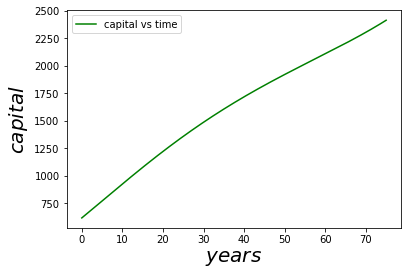

In [19]:
# To plot capital, plot v[:,0] instead of v[:,1]

plt.plot(t,v[:,0], 'g', label="capital vs time")
plt.legend()
plt.xlabel('$years$',size=20)
plt.ylabel('$capital$',size=20);
print(v[-1])

# Backward solve the system of equations:

In [ ]:
# solve for the systems of equations for c0:
error = 0.01

#full commitment
tf= 424.774
#tf = 79.5764

plt.plot([0,tf], [cinf_steady[table_i], cinf_steady[table_i]], 'r--', label="full commitment steady state")

init_pt = [kinf_steady[table_i], cinf_steady[table_i]-error]
t, v = plot_time_series(full_commitment, init_pt,[tf,0])
plt.plot(t,v[:,1], 'r', label="full commitment")
full_commit_c0 = v[-1][1]
print(f'[k(0), c(0)] for full commitment is currently {v[-1]}')
print()

#no commitment
plt.plot([0,tf], [c0_steady[table_i], c0_steady[table_i]], 'g--', label="no commitment steady state")
tf= 342.489
#tf = 79.5764

init_pt = [k0_steady[table_i], c0_steady[table_i]-error] #short-term steady state - no commitment

t, v = plot_time_series(no_commitment, init_pt, [tf,0])
plt.plot(t,v[:,1], 'g', label="no commitment")
no_commit_c0 = v[-1][1]
print(f'[k(0), c(0)] for no commitment is currently {v[-1]}')

# make the graph prettier
plt.legend();
plt.xlabel('$years$',size=20)
plt.ylabel('$consumption$',size=20);


### Plugging the resulting c0 values into the forward solver (which decides the shape of the graphs) but not the k0 value, which should always be .25 $k^{*}_{0}$:

##### we want the curve to follow the steady state and not shoot off into infinity or to zero

In [ ]:
tf= 75
init_k0 = .25*k0_steady[0]
error = 0.01

#full commitment
plt.plot([0,tf], [cinf_steady[table_i], cinf_steady[table_i]], 'r--', label="full commitment steady state")

t, v = plot_time_series(full_commitment, [init_k0, full_commit_c0], [0,tf])
plt.plot(t,v[:,1], 'r', label="full commitment")
print(f'[k({tf}), c({tf})] for full commitment is currently {v[-1]}')
print()

#no commitment
plt.plot([0,tf], [c0_steady[table_i], c0_steady[table_i]], 'g--', label="no commitment steady state")

t, v = plot_time_series(no_commitment, [init_k0,  no_commit_c0],[0,tf])
#t, v = plot_IVP(no_commitment, [init_k0,  no_commit_c0],[0,tf])
plt.plot(t,v[:,1], 'g', label="no commitment")
print(f'[k({tf}), c({tf})] for no commitment is currently {v[-1]}')

# make the graph prettier
plt.legend();
plt.xlabel('$years$',size=20)
plt.ylabel('$consumption$',size=20);


# Using the Time-elimination method:

This is easy for no commitment since no commitment does not contain time in its equations, but this will be tricky for full commitment. The time elimination method can be seen in the code when plot_IVP is used.

In [ ]:
#full_commitment = [lambda t, k,c : k**Œ±-c-(Œ¥+x+n)*k, lambda t, k,c : c*(Œ±*k**(Œ±-1)-Œ¥-x-œÅ-b*np.exp(-Œ≥*(t-œÑ)))]
full_commitment = [lambda t, k,c : k**Œ±-c-(Œ¥+x+n)*k, lambda t, k,c : c*(Œ±*k**(Œ±-1)-Œ¥-x-œÅ)] # when time is small, this doesn't work

no_commitment = [lambda t, k,c : k**Œ±-c-(Œ¥+x+n)*k, lambda t, k,c : c*(Œ±*k**(Œ±-1)-Œ¥-x-Œª)]

### No commitment:

In [ ]:
plot_flow(no_commitment, [0, 3000], [0, 200], 20)

plt.plot([0,3000], [c0_steady[table_i], c0_steady[table_i]], 'r--', label="k nullcline")
plt.plot([k0_steady[table_i], k0_steady[table_i]],[0,200], 'b--', label="c nullcline")

error = 1
tf = 500
backward_init_pt = [k0_steady[table_i], c0_steady[table_i]-error] #short-term steady state - no commitment
plot_IVP(no_commitment, backward_init_pt, [tf, 0]);

### full-commitment:

In [ ]:
plot_flow(full_commitment, [0, 5000], [0, 200], 20)

plt.plot([0,5000], [cinf_steady[table_i], cinf_steady[table_i]], 'r--', label="k nullcline")
plt.plot([kinf_steady[table_i], kinf_steady[table_i]],[0,200], 'b--', label="c nullcline")

error = 1
tf = 500
backward_init_pt = [kinf_steady[table_i]-error, cinf_steady[table_i]-error] #short-term steady state - no commitment
plot_IVP(full_commitment, backward_init_pt, [tf, 0]);
print(f'[k(0), c(0)] for no commitment is currently {v[-1]}')


## Using the Jacobian

the intuition here, as I understand it, is that zooming into the equilbrium points can help us get a better understanding of the functions. Also, using the Jacobian is the process of normalizing our functions, which should also help us understand our functions better. Viewing the Jacobian flow plot is also like viewing the time-elimination graph zoomed in. For instance, for no commitment, the equation didn't need to be modified, but for full commitment, the equation was modified by getting rid of $be^{-\gamma(t-\tau)}$, reducing the equation to $\dot{c}=c\left(\alpha k^{\alpha-1}-\delta-x-\rho\right)$ Note that this only makes sense when looking at the long-term equilibrium point because $\lim_{x \to \infty} b e^{-\gamma(t-\tau)} = 0$

##### Full commitment:

$ \begin{array}{l}
\dot{c}=c\left(\alpha k^{\alpha-1}-\delta-x-\rho-b e^{-\gamma(t-\tau)}\right)
\mbox{   becomes   } \dot{c}=c\left(\alpha k^{\alpha-1}-\delta-x-\rho\right)\\
\dot{k}=k^{\alpha}-c-(\delta+x+n) k
\end{array}$

##### No commitment:

$ \begin{array}{l}
\dot{c}=c\left(\alpha k^{\alpha-1}-\delta-x-\lambda\right) \\
\dot{k}=k^{\alpha}-c-(\delta+x+n) k
\end{array}$

In [ ]:
lam = .03653
alpha, delta, xt, n, rho, b, gamma = Œ±, Œ¥, x, n, œÅ, b, Œ≥
r = (Œ±, Œ¥, x, n, œÅ, b, Œ≥)

eq = nullcline_intersection(dFull,r)
kstar, cstar = eq[0][0], eq[0][1]
ca, cb, ka, kb = 1e-6, cstar *1.1, 1e-6, kstar * 1.1

##### No Commitment:

In [ ]:
# Equations of k*_0 and c*_0 for No Commitment
kzed = (alpha/(delta + lam + xt))**(1/(1-alpha)) 
czed = kzed**alpha - (delta + n + xt)*kzed 

eq = nullcline_intersection(dNo,r)
c = np.linspace(ca-czed,cb-czed)
k = np.linspace(ka-kzed,kb-kzed)
JNo = jacsysFC(kstar,cstar,r)
JentriesNo = (JNo[0,0],JNo[0,1],JNo[1,0],JNo[1,1])


print("The Jacobian Matrix of the No Committment case:")
print(JNo)
print(" ")
print("The Eigenvalues and Eigenvectors of the No Commmittment Case:")
print(np.linalg.eig(JNo))

In [ ]:
UpLfQ = [-0.005, .005]  # Value in upper left quadrant (Blue)
UpRtQ = [0.01, .005]   # Value in upper right quadrant (Red)
LwLfQ = [-0.01, -0.005] # Value in lower left quadrantn(Purple)
LwRtQ = [0.005, -0.005]  # Value in lower right quadrant (Yellow)

# Values in the Jacobian of the No Comittment Case
JentriesNo = np.array([[JNo[0,0],JNo[0,1]],[JNo[1,0],JNo[1,1]]])
print(JentriesNo)

tNo,vNo = rk4_solve(0,2,1e-2, UpLfQ,F,JNo)
tNo2,vNo2 = rk4_solve(0,2,1e-2, UpRtQ,F,JNo)
tNo3,vNo3 = rk4_solve(0,2,1e-2, LwLfQ,F,JNo)
tNo4,vNo4 = rk4_solve(0,2,1e-2, LwRtQ,F,JNo)

plt.plot(vNo[:,0],vNo[:,1], 'b',vNo2[:,0], vNo2[:,1],'r',vNo3[:,0], vNo3[:,1],'m',vNo4[:,0], vNo4[:,1],'y',
         [-.005,.0050],[0,0],'k',[0,0],[-.0050, .0050],'k');
plt.xlabel('k',size=15)
plt.ylabel('c',size=15);

###### The paths around the stable point, displaying the saddle paths for above the stable point.

The green circle is the starting point, and the direction the line goes shows the character of how that point reacts around the steady state.

In [ ]:
plt.plot(vNo[:,0],vNo[:,1], 'b', vNo2[:,0],vNo2[:,1], 'r',
         [0,0],[0.00499,.00505], 'black', [-.014, .010], [.00499,.00499], 'black',UpRtQ[0],UpRtQ[1],'mo',UpLfQ[0],UpLfQ[1],'mo');
plt.xlabel('k',size=15)
plt.ylabel('c',size=15);

In [ ]:
plt.plot(vNo3[:,0],vNo3[:,1], 'm', vNo4[:,0],vNo4[:,1], 'y',
         [0,0],[-0.00499,-0.005015], 'black', [-.010, .015], [-0.00499,-.00499], 'black', LwRtQ[0],LwRtQ[1],'go',LwLfQ[0],LwLfQ[1],'go');
plt.xlabel('k',size=15)
plt.ylabel('c',size=15);

#####  Full Commitment:

In [ ]:
alpha, delta, xt, n, rho, b, gamma = 0.75, 0.05, 0.02, 0.01, 0.02, 0.5, 0.5
r = (alpha, delta, xt, n, rho, b, gamma)


# Equations of k*_inf and c*_inf for Full Commitment
kinf = (alpha/(delta + rho + xt))**(1/(1-alpha)) 
cinf = kinf**alpha - (delta + n + xt)*kinf 

eq = nullcline_intersection(dFull,r)
c = np.linspace(ca-cinf,cb-cinf)
k = np.linspace(ka-kinf,kb-kinf)
Jinf = jacsysFC(kstar,cstar,r)
Jentries = (Jinf[0,0],Jinf[0,1],Jinf[1,0],Jinf[1,1])

print("The Jacobian Matrix of the Full Committment case:")
print(Jinf)
print(" ")
print("The Eigenvalues and Eigenvectors of the Full Commmittment Case:")
print(np.linalg.eig(Jinf))

In [ ]:
UpLfQ = [-0.005, .005]  # Value in upper left quadrant (Blue)
UpRtQ = [0.01, .005]   # Value in upper right quadrant (Red)
LwLfQ = [-0.01, -0.005] # Value in lower left quadrantn(Purple)
LwRtQ = [0.005, -0.005]  # Value in lower right quadrant (Yellow)

# Values in the Jacobian of the No Comittment Case
JentriesInf = np.array([[Jinf[0,0],Jinf[0,1]],[Jinf[1,0],Jinf[1,1]]])
JentriesInf = np.array([[Jinf[0,0],-1],[Jinf[1,0],0]])

print(JentriesInf)


tinf,vinf = rk4_solve(0,4,1e-2, UpLfQ,F,JentriesInf)
tinf2,vinf2 = rk4_solve(0,2,1e-2, UpRtQ,F,JentriesInf)
tinf3,vinf3 = rk4_solve(0,2,1e-2, LwLfQ,F,JentriesInf)
tinf4,vinf4 = rk4_solve(0,2,1e-2, LwRtQ,F,JentriesInf)

#np.shape(v)
plt.plot(vinf[:,0],vinf[:,1], 'b',vinf2[:,0], vinf2[:,1],'r',vinf3[:,0], vinf3[:,1],'m',vinf4[:,0], vinf4[:,1],'y',
         [-.009,.009],[0,0],'k',[0,0],[-.009, .009],'k');

plt.xlabel('k',size=15)
plt.ylabel('c',size=15);

###### The paths around the stable point, displaying the saddle paths for above the stable point.

The green circle is the starting point, and the direction the line goes shows the character of how that point reacts around the steady state.

In [ ]:
plt.plot(vinf[:,0],vinf[:,1], 'b', vinf2[:,0],vinf2[:,1], 'r',
         [0,0],[0.00499,.00505], 'black', [-.025, .010], [.00499,.00499], 'black',UpRtQ[0],UpRtQ[1],'go',UpLfQ[0],UpLfQ[1],'go');
plt.xlabel('k',size=15)
plt.ylabel('c',size=15);

###### The paths around the stable point, displaying the saddle paths for below the stable point.

In [ ]:
plt.plot(vinf3[:,0],vinf3[:,1], 'm', vinf4[:,0],vinf4[:,1], 'y',
         [0,0],[-0.00499,-0.005015], 'black', [-.010, .015], [-0.00499,-.00499], 'black', LwRtQ[0],LwRtQ[1],'go',LwLfQ[0],LwLfQ[1],'go');
plt.xlabel('k',size=15)
plt.ylabel('c',size=15);

# Messing with Perturbation for the Backward Solver of Full Commitment:

this is to get rid of the reliance on the tf value above, so that we can give it any tf value, and it finds the correct perturbation value so that $k_0 \approx 614.22$

Note that no commitment does not need these considerations because the time-elimination method works (due to it not containing time within its functions for c-dot and k-dot)

Due to the nature of full commitment not being solvable by the same means no commitment was (the time elimination method by which the time variable is effectively removed from the equation as it was implicit in nature and can simply be removed by performing those operations), the full commitment case must be solved backwards from the equilibrium values found previously through solving the system of equations, the ‚Äúsolution‚Äù that will be found by this solver will come at roughly k(0) which had been calculated to be one quarter (¬º) of k(0) (this is the equilibrium solution for the non-commitment case of a given system, ex: $k_0^*=2459.49884228438$ by which k(0) is roughly 614.22 for column 1) By using a ‚Äúshooting‚Äù method alongside a numerical value estimation technique such as the bisection or secant method (by which were chosen due to their non-reliance on taking a derivative as the given equations would not be easy to work with in terms of their derivatives). This means we can therefore ‚Äúget off‚Äù or perturb on both sides of the equilibrium solution (above and below) for c*(inf) (ex: 192.90 for column 1), we can safely narrow down where exactly the initial point must be in order for the given equations to result in that equilibrium solution that was the starting point of the solver. Thus as an example (which may or may not be shown below) for the first column this resulting value is roughly 77.2. The benefit of this implementation in particular is the only variables that are needed to be given to solve for this value are a final time value (ex: 120 for columns 1-3 seemed to be a good fit) and a maximum iteration count by which is essentially just a limit for how many iterations the solver is required/allowed to do before giving up (by which does not seem to be reached unless set fairly/very low



### The methods we tried for finding the perturbation:

In [ ]:
def LF_secant_method(MAX_IT, tolerance):
    
    tic = timeit.default_timer()
    i=0
    error = tolerance+1
    eps = 1e-4
    
    c_upper = cinf_steady[table_i]+eps #the "plus eps" is to give something other than the steady state
    c_lower = cinf_steady[table_i]-eps
    k_init = kinf_steady[table_i]
    
    #find initial k_upper
    init_pt = [k_init, c_upper]
    t, v = plot_time_series(full_commitment, init_pt,[tf,0]) #backward solve
    k_upper = v[-1][0]
        
    #find initial k_lower
    init_pt = [k_init, c_lower]
    t, v = plot_time_series(full_commitment, init_pt,[tf,0]) #backward solve
    k_lower = v[-1][0]
    
    
    while (i<MAX_IT and error > tolerance):
        
        # Evalute the function
        fl = k_lower-init_k0
        fu = k_upper-init_k0
        
        #find c_upper and c_lower
        tmp = c_upper
        c_upper = c_lower - fl*(c_upper-c_lower)/(fu-fl) #need to use the old c_lower
        c_lower = tmp
        
        #find k_upper
        init_pt = [k_init, c_upper]
        t, v = plot_time_series(full_commitment, init_pt,[tf,0]) #backward solve
        k_upper = v[-1][0]

        #find k_lower
        init_pt = [k_init, c_lower]
        t, v = plot_time_series(full_commitment, init_pt,[tf,0]) #backward solve
        k_lower = v[-1][0]
        
        # Compute the error using the Cauchy-criterion for convergence
        error = np.fabs(c_lower-c_upper)
        i+=1
        print(f'iteration {i}')
        
    toc = timeit.default_timer()
    
    cstart = (init_k0-k_lower)*(c_upper-c_lower)/(k_upper-k_lower)+c_lower
    init_pt = [k_init, cstart]
    
    print('Run complete in {:4.2f} seconds.'.format(toc-tic))   
    return p


In [ ]:
def LF_bisection_method(bound, MAX_IT, tolerance):
    
    tic = timeit.default_timer()
    i=0
    error = tolerance+1
    
    while (i<MAX_IT and error > tolerance):
        
        p = (bound[0]+bound[1])/2
        
        init_pt = [kinf_steady[table_i], cinf_steady[table_i]-p]
        
        t, v = plot_time_series(full_commitment, init_pt,[tf,0]) #backward solve
        found_k0 = v[-1][0]
        
        if(found_k0 < init_k0):
            bound = [bound[0], p]
        
        elif(found_k0 > init_k0):
            bound = [p, bound[1]]
        
        else:
            break
        
        error = np.fabs(bound[0]-bound[1])/2
        i+=1
        print(f'iteration {i}')
        
        
    toc = timeit.default_timer()
    
    #To-do: add interpolation here for more accuracy
    
    print('Run complete in {:4.2f} seconds.'.format(toc-tic))   
    return p, bound
    

In [ ]:
def LF_machine_gun_method(bound, error):
    for p in np.arange(bound[0],bound[1],error):

        init_pt = [kinf_steady[table_i], cinf_steady[table_i]-p]

        t, v = plot_time_series(full_commitment, init_pt,[tf,0])
        found_c0 = v[-1][0]
        #print(found_c0)
        
        if(found_c0 < init_k0):
            toc = timeit.default_timer()
            print('Run complete in {:4.2f} seconds.'.format(toc-tic))
            return p
        

### Backward solving with the Bisection method for finding the perturbation:

In [ ]:
full_commitment = [lambda t, k,c : k**Œ±-c-(Œ¥+x+n)*k, lambda t, k,c : c*(Œ±*k**(Œ±-1)-Œ¥-x-œÅ-b*np.exp(-Œ≥*(t-œÑ)))]

# solve the systems of equations for c0:
tf = 120

#full commitment steady state
plt.plot([0,tf], [cinf_steady[table_i], cinf_steady[table_i]], 'b--', label="full commitment steady state")

#solve for the perturbation off of the steady state that gives us an adequate c0
tolerance = 1e-4
MAX_IT=50
p, bound_of_p = LF_bisection_method([0,100], MAX_IT, tolerance)

#plot with the found perturbation
init_pt = [kinf_steady[table_i], cinf_steady[table_i]-p]
t, v = plot_time_series(full_commitment, init_pt,[tf,0])
plt.plot(t,v[:,1], 'r', label="full commitment")
print(f'[k(0), c(0)] for full commitment is currently {v[-1]}')

### Backward solving with the Secant method for finding the perturbation:

In [ ]:
#full commitment steady state
plt.plot([0,tf], [cinf_steady[table_i], cinf_steady[table_i]], 'b--', label="full commitment steady state")

#solve for the perturbation off of the steady state that gives us an adequate c0
perturbation = LF_secant_method(MAX_IT, tolerance)

#plot with the found perturbation:
init_pt = [kinf_steady[table_i], cinf_steady[table_i]-perturbation]        
t, v = plot_time_series(full_commitment, init_pt,[tf,0])
plt.plot(t,v[:,1], 'r', label="full commitment")
print(f'[k(0), c(0)] for full commitment is currently {v[-1]}')